In [14]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
%matplotlib inline
from sklearn.model_selection import train_test_split

train = pd.read_csv('data/digit-recognizer/train.csv')
test = pd.read_csv('data/digit-recognizer/test.csv')

In [15]:
train.shape, test.shape

((42000, 785), (28000, 784))

## Data Preprocessing

In [16]:
'''
import pickle
import gzip
def load_data():
    f = gzip.open('/home/pratik/ml_workspace/Classification/NN/MNIST/dataset/mnist.pkl.gz', 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
    f.close()
    return p

def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

training_data, validation_data, test_data = load_data_wrapper()
'''
print("Pickle Data for reference")

Pickle Data for reference


In [17]:
#Complete Training data 
y_tr = train['label'].values
X_tr = train.drop(columns=['label']).values/255

#Test data fot prediction
X_test = test.values/255

#Splitting data 
X_train = X_tr[:30000]
y_train = y_tr[:30000]
test_x = X_tr[30000:42000]
test_y = y_tr[30000:42000]

In [18]:
X_train.shape, y_train.shape, test_x.shape, test_y.shape

((30000, 784), (30000,), (12000, 784), (12000,))

In [19]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [20]:
def process_data():
    #Trainig Data
    training_inputs = [np.reshape(x, (784, 1)) for x in X_train]
    training_results = y_train#[vectorized_result(y) for y in train_y]
    training_data = list(zip(training_inputs, training_results))
    #Test Data
    test_inputs = [np.reshape(x, (784, 1)) for x in test_x]
    test_data = list(zip(test_inputs, test_y))
    return (training_data, test_data)

training_data , test_data = process_data() 


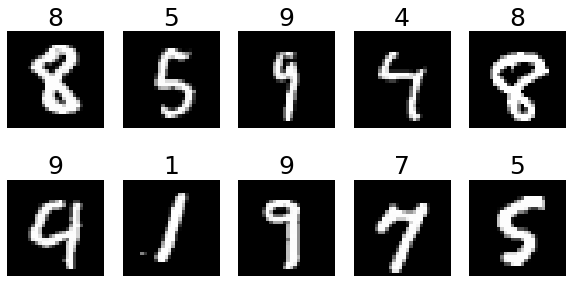

In [21]:
fig, axes = plt.subplots(2,5, figsize=(10,5))
axes = axes.flatten()
idx = np.random.randint(0,30000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [22]:
print("----Traininig data----")
y_value=np.zeros((1,10))
for i in range (10):
    print("Occurance of ",i,"=",np.count_nonzero(y_train==i))
    y_value[0,i-1]= np.count_nonzero(y_train==i)

----Traininig data----
Occurance of  0 = 2937
Occurance of  1 = 3332
Occurance of  2 = 3020
Occurance of  3 = 3093
Occurance of  4 = 2932
Occurance of  5 = 2719
Occurance of  6 = 2970
Occurance of  7 = 3133
Occurance of  8 = 2889
Occurance of  9 = 2975


<BarContainer object of 10 artists>

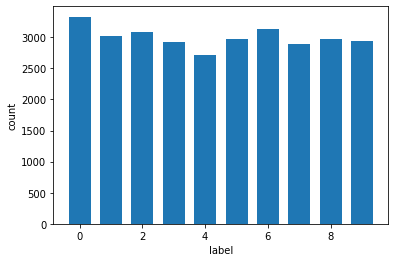

In [23]:
y_value=y_value.ravel()
x_value=[0,1,2,3,4,5,6,7,8,9]

plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7)

# Neural Network model

In [24]:
class NeuralNetwork(object):
    
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def softmax(self,x):
        expA = np.exp(x)
        return expA / expA.sum()
    
    def sigmoidPrime(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def forward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a
    
    def cost(self, y_hat, y):
        m = y_hat.shape[1]
        cost = -1 / m * (np.dot(y.T, np.log(y_hat)) + np.dot((1 - y).T, np.log(1 - y_hat)))
        return np.squeeze(cost)
    
    def backprop(self, x, y):
        b_up = [np.zeros(b.shape) for b in self.biases]
        w_up = [np.zeros(w.shape) for w in self.weights]
        
        #Feed forward
        activation = x
        activations = [x] 
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        
        #Backpass
        delta = self.cost_derivative(activations[-1], y) * self.sigmoidPrime(zs[-1])
        b_up[-1] = delta
        w_up[-1] = np.dot(delta, activations[-2].transpose())
        
        #Updation terms
        for l in range(2, self.num_layers):
            z = zs[-l]
            delta = np.dot(self.weights[-l+1].transpose(), delta) * self.sigmoidPrime(z)
            b_up[-l] = delta
            w_up[-l] = np.dot(delta, activations[-l-1].transpose())
        
        return (b_up, w_up)
        
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,test_data=None):
        
        if test_data: n_test = len(test_data)
        
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))
                
    def update_mini_batch(self, mini_batch, eta):
        
        b_up = [np.zeros(b.shape) for b in self.biases]
        w_up = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_b_up, delta_w_up = self.backprop(x, y)
            b_up = [bu+dnb for bu, dnb in zip(b_up, delta_b_up)]
            w_up = [wu+dnw for wu, dnw in zip(w_up, delta_w_up)]
        
        #Updating the weights and biases
        self.weights = [w-(eta/len(mini_batch))*wu for w, wu in zip(self.weights, w_up)]
        self.biases = [b-(eta/len(mini_batch))*bu for b, bu in zip(self.biases, b_up)] 
        
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.forward(x)), y) for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)    

In [25]:
nn = NeuralNetwork([784,30,10])

In [26]:
nn.SGD(training_data, 30, 10, 3, test_data=test_data)

Epoch 0: 1515 / 12000
Epoch 1: 1484 / 12000
Epoch 2: 1474 / 12000
Epoch 3: 1458 / 12000
Epoch 4: 1440 / 12000
Epoch 5: 1453 / 12000
Epoch 6: 1444 / 12000
Epoch 7: 1428 / 12000
Epoch 8: 1427 / 12000
Epoch 9: 1424 / 12000
Epoch 10: 1417 / 12000
Epoch 11: 1416 / 12000
Epoch 12: 1421 / 12000
Epoch 13: 1423 / 12000
Epoch 14: 1417 / 12000
Epoch 15: 1423 / 12000
Epoch 16: 1416 / 12000
Epoch 17: 1410 / 12000
Epoch 18: 1406 / 12000
Epoch 19: 1397 / 12000
Epoch 20: 1391 / 12000
Epoch 21: 1387 / 12000
Epoch 22: 1386 / 12000
Epoch 23: 1381 / 12000
Epoch 24: 1381 / 12000
Epoch 25: 1380 / 12000
Epoch 26: 1382 / 12000
Epoch 27: 1378 / 12000
Epoch 28: 1377 / 12000
Epoch 29: 1380 / 12000
